# Evaluation

In [1]:
import cv2
import glob
import os
import shutil
import re
import random
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
from openslide import OpenSlide
from multiprocessing import Pool

# GPU use
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

from model import *

## Settings

In [2]:
CROP_SIZE = 2048
OVERLAP = 64
GAUSS_STD = 10
BATCH_SIZE = 4
WEIGHT_PATH = "h5/train_gauss/unet.h5"
test_wsi_ids = [3, 10, 14, 15, 18, 21, 22]

In [3]:
DB = sqlite3.connect("MITOS_WSI_CMC/databases/MITOS_WSI_CMC_CODAEL_TR_ROI.sqlite")
    
file_df = pd.read_sql("SELECT * FROM Slides", DB)
label_df = pd.read_sql("SELECT * FROM Annotations", DB)
mitosis_df = label_df[label_df["agreedClass"]==2]
notmitosis_df = label_df[label_df["agreedClass"]==1]
coordinates_df = pd.read_sql("SELECT * FROM Annotations_coordinates", DB)

## Divide WSI into ROIs

In [4]:
def save_crop_image(wsi_path, wsi_id, crop_size=CROP_SIZE, overlap=OVERLAP, glass_region_th=200):
    """
    Crop and save images from WSI.
    Path of the cropped image.
        crop_image/{crop_size}_{overlap}/{wsi_id}/{left top x of WSI}_{left top y of WSI}.png

    Parameters
    ----------
    wsi_path : str
    wsi_id : int
    crop_size : int
        Image size of the cropped images.
    overlap : int
        Number of pixels that overlap with adjacent cropped images.
    glass_region_th : int (default : 200)
        Threshold to determine the glass part of the slide.
        The area judged as the glass part is not saved.
        
    Returns
    -------
    Nothing.
    """   
    wsi = OpenSlide(wsi_path)
    wsi_w, wsi_h = wsi.dimensions
    level = wsi.level_count
    zoom = wsi.level_downsamples[level-1]
    save_dir = "crop_image/{}_{}/{}".format(crop_size, overlap, wsi_id)
    
    if os.path.exists(save_dir):
        shutil.rmtree(save_dir)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    iter_h = wsi_h//(crop_size-overlap)
    iter_w = wsi_w//(crop_size-overlap)
    for i in range(iter_h):
        for j in range(iter_w):
            location = (j*(crop_size-overlap), i*(crop_size-overlap))
            roi = wsi.read_region(location, level-1, (int(crop_size/zoom), int(crop_size/zoom)))
            if np.min(np.array(roi.convert("L")))<glass_region_th:
                img = wsi.read_region(location, 0, (crop_size, crop_size))
                img.save("{}/{}_{}.png".format(save_dir, location[0], location[1]))

In [5]:
slide_list = glob.glob("MITOS_WSI_CMC/WSI/*.svs")

zip_list = []
for slide_path in slide_list:
    filename = slide_path.split("/")[-1]
    filedata = file_df[file_df["filename"]==filename]
    wsi_id = filedata.iat[0, 0]
    zip_list.append([slide_path, wsi_id])

# To give multiple arguments
def wrapper(args):
    return save_crop_image(*args) 

# multiprocessing
multi_num = 8
p = Pool(multi_num)
p.map(wrapper, zip_list)
p.close()

## Predict ROIs

In [6]:
def predict(wsi_id, weight_path=WEIGHT_PATH, crop_size=CROP_SIZE, overlap=OVERLAP):
    """
    Predict the cropped image.
    Path of the predicted image.
        predict_image/{crop_size}_{overlap}/{train or test}/{wsi_id}/{left top x of WSI}_{left top y of WSI}.png

    Parameters
    ----------
    wsi_id : int
    weight_path : str
    crop_size : int
        Image size of the cropped images.
    overlap : int
        Number of pixels that overlap with adjacent cropped images.
        
    Returns
    -------
    Nothing.
    """
    if not os.path.exists("crop_image/{}_{}/{}".format(crop_size, overlap, wsi_id)):
        print("crop_image/{}_{}/{} does not exist!!".format(crop_size, overlap, wsi_id))
        return 0

    crop_list = glob.glob("crop_image/{}_{}/{}/*".format(crop_size, overlap, wsi_id))
    model = unet((crop_size, crop_size, 3))
    
    if os.path.exists("{}".format(weight_path)):
        model.load_weights("{}".format(weight_path))
    else:
        print("Weight path is not correct.")
        return 0

    if wsi_id in test_wsi_ids:
        save_dir = "predict_image/{}_{}/test/{}".format(crop_size, overlap, wsi_id)
    else:
        save_dir = "predict_image/{}_{}/train/{}".format(crop_size, overlap, wsi_id)
    
    print("Now processing wsi id : {}".format(wsi_id))
    
    if os.path.exists(save_dir):
        shutil.rmtree(save_dir)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    for crop_path in crop_list:
        img = cv2.imread(crop_path)
        l = re.split("/|_|\.", crop_path)
        location = (int(l[-3]), int(l[-2]))
        image_size = img.shape[:2]
        img_conv = img[:,:,::-1] / 255
        img_conv = np.reshape(img_conv,(1,)+img_conv.shape)
        
        unet_pred = model.predict_on_batch(img_conv)
        unet_pred = np.squeeze(unet_pred)
        unet_pred = np.array(unet_pred*255, dtype=np.uint8)
      
        cv2.imwrite("{}/{}_{}.png".format(save_dir, location[0], location[1]), unet_pred[:,:,::-1])

In [7]:
slide_list = glob.glob("MITOS_WSI_CMC/WSI/*.svs")

for slide_path in slide_list:
    filename = slide_path.split("/")[-1]
    filedata = file_df[file_df["filename"]==filename]
    wsi_id = filedata.iat[0, 0]
    predict(wsi_id)

Now processing wsi id : 19
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Now processing wsi id : 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Now processing wsi id : 1
Please report this to the TensorFlow team. When filing the bug, set the verbo

## Threshold and result

In [15]:
def threshold(wsi_id, th, crop_size=CROP_SIZE, overlap=OVERLAP, test_mode=True):
    """
    Extract only the mitotic channel from the U-Net output, binarize it, 
    perform blob detection, and write the detected coordinates to a text file.
    The text file contains a space-delimited list of detected point coordinates in x,y format.
    Example : 23,543 650,938 759,980 ... x,y ...
    
    Path of the text file.
        threshold/{crop_size}_{overlap}/{th}/{train or test}/{wsi_id}.txt

    Parameters
    ----------
    wsi_id : int
    th : int
        Threshold value used in the binarization process, ranging from 0 to 255.
    crop_size : int
        Image size of the cropped images.
    overlap : int
        Number of pixels that overlap with adjacent cropped images.
    
        
    Returns
    -------
    Nothing.
    """
#     print("参数列表：")
#     print("wsi_id：{}".format(wsi_id))
#     print("th：{}".format(th))
#     print("crop_size：{}".format(crop_size))
#     print("OVERLAP：{}".format(OVERLAP))
#     print("test_mode：{}".format(test_mode))
    
    if test_mode==True:
        read_dir = "predict_image/{}_{}/test/{}".format(crop_size, overlap, wsi_id)
        save_dir = "threshold/{}_{}/{}/test".format(crop_size, overlap, th)
    else:
        read_dir = "predict_image/{}_{}/train/{}".format(crop_size, overlap, wsi_id)
        save_dir = "threshold/{}_{}/{}/train".format(crop_size, overlap, th)

    if not os.path.exists(read_dir):
        #print("{} does not exist!!".format(read_dir))
        return 0
    else:
        pre_list = glob.glob("{}/*".format(read_dir))    

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    if os.path.exists("{}/{}.txt".format(save_dir, wsi_id)):
        os.remove("{}/{}.txt".format(save_dir, wsi_id))
        
    with open("{}/{}.txt".format(save_dir, wsi_id), mode='a') as f:
        for pre_path in pre_list:
            pre = cv2.imread(pre_path)
            l = re.split("/|_|\.", pre_path)
            location = (int(l[-3]), int(l[-2]))
            ret, img_th = cv2.threshold(pre[overlap:-overlap, overlap:-overlap, 2], th, 255, cv2.THRESH_BINARY)
            label = cv2.connectedComponentsWithStats(img_th)
            n = label[0] - 1
            center_pre = np.delete(label[3], 0, 0)

            for x,y in center_pre:
                f.write("{},{} ".format(int(x+overlap+location[0]), int(y+overlap+location[1]))) 

In [42]:
th_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180 ,190, 200, 210, 220, 230, 240, 250]
#th_list = [10, 120, 250]
slide_list = glob.glob("MITOS_WSI_CMC/WSI/*.svs")
test_mode = True  # True at time of testing
for th in th_list:
    zip_list = []
    print("Now processing threshold : {}".format(th))
    for slide_path in slide_list:
        filename = slide_path.split("/")[-1]
        filedata = file_df[file_df["filename"]==filename]
        wsi_id = filedata.iat[0, 0]
        zip_list.append([wsi_id, th, CROP_SIZE, OVERLAP, test_mode])

    # To give multiple arguments
    def wrapper(args):
        return threshold(*args) 

    # multiprocessing
    multi_num = 1
    p = Pool(multi_num)
    p.map(wrapper, zip_list)
    p.close()

Now processing threshold : 10
Now processing threshold : 20
Now processing threshold : 30
Now processing threshold : 40
Now processing threshold : 50
Now processing threshold : 60
Now processing threshold : 70
Now processing threshold : 80
Now processing threshold : 90
Now processing threshold : 100
Now processing threshold : 110
Now processing threshold : 120
Now processing threshold : 130
Now processing threshold : 140
Now processing threshold : 150
Now processing threshold : 160
Now processing threshold : 170
Now processing threshold : 180
Now processing threshold : 190
Now processing threshold : 200
Now processing threshold : 210
Now processing threshold : 220
Now processing threshold : 230
Now processing threshold : 240
Now processing threshold : 250


## Evaluation
True positive (TP) is defined as the prediction point is within a 25 pixel radius of the annotated point.

False negative (FN) is defined when there is no prediction point within a 25 pixel radius of the annotated point.

False positive (FP) is defined when there is no annotated point within a 25 pixel radius of the prediction point.

Precision indicates the accuracy of the prediction.

$Precision=\frac{TP}{TP + FP}$  

Recall indicates how well the GT were detected without omission.  

$Recall=\frac{TP}{TP + FN}$  

If we detect only easily distinguishable objects, Precision will increase, but Recall will decrease. Conversely, if the number of predictions increases, Recall increases but Precision decreases. F1 score is a comprehensive index that evaluates Recall and Precision.  

$F1 score=\frac{2 \times Precision \times Recall}{Precision + Recall}$

Evaluate the performance of the model using F1score.

In [43]:
def nms(xy_list, radius: float = 25):
    
    X = xy_list
    tree = KDTree(X)

    radius=25
    ind = tree.query_radius(X, r=radius)
    dup_idx = []
    for i in ind:
        if len(i)>1:
            for j in i[1:]:
                if not j in dup_idx:
                    dup_idx.append(j)
    for i in reversed(sorted(dup_idx)):
        xy_list.pop(i)

    return xy_list


def _F1_core(centers_DB : np.ndarray, xy_list):
    center_x = xy_list[:, 0] 
    center_y = xy_list[:, 1]
    
    isDet = np.zeros(xy_list.shape[0]+centers_DB.shape[0])
    isDet[0:xy_list.shape[0]]=1 # mark as detection, rest ist GT

    if (centers_DB.shape[0]>0):
        center_x = np.hstack((center_x, centers_DB[:,0]))
        center_y = np.hstack((center_y, centers_DB[:,1]))
        
    # set up kdtree 
    X = np.dstack((center_x, center_y))[0]

    if (X.shape[0]==0):
        return 0,0,0,0

    try:
        tree = KDTree(X)
    except:
        print('Shapes of X: ',X.shape)
        raise Error()

    radius = 25
    ind = tree.query_radius(X, r=radius)

    annotationWasDetected = {x: 0 for x in np.where(isDet==0)[0]}
    DetectionMatchesAnnotation = {x: 0 for x in np.where(isDet==1)[0]}

    # check: already used results
    alreadyused=[]
    for i in ind:
        if len(i)==0:
            continue
        if np.any(isDet[i]) and np.any(isDet[i]==0):
            # at least 1 detection and 1 non-detection --> count all as hits
            for j in range(len(i)):
                if not isDet[i][j]: # is annotation, that was detected
                    if i[j] not in annotationWasDetected:
                        print('Missing key ',j, 'in annotationWasDetected')
                        raise ValueError('Ijks')
                    annotationWasDetected[i[j]] = 1
                else:
                    if i[j] not in DetectionMatchesAnnotation:
                        print('Missing key ',j, 'in DetectionMatchesAnnotation')
                        raise ValueError('Ijks')

                    DetectionMatchesAnnotation[i[j]] = 1

    #TP = np.sum([annotationWasDetected[x]==1 for x in annotationWasDetected.keys()])
    TP = [X[x] for x, y in annotationWasDetected.items() if y==1]
    #FN = np.sum([annotationWasDetected[x]==0 for x in annotationWasDetected.keys()])
    FN = [X[x] for x, y in annotationWasDetected.items() if y==0]
    #FP = np.sum([DetectionMatchesAnnotation[x]==0 for x in DetectionMatchesAnnotation.keys()])
    FP = [X[x] for x, y in DetectionMatchesAnnotation.items() if y==0]
    #F1 = 2*TP/(2*TP + FP + FN)

    #return F1, TP, FP, FN
    return TP, FP, FN


def calculate_F1(result_dir=None, databasefile='MITOS_WSI_CMC/databases/MITOS_WSI_CMC_CODAEL_TR_ROI.sqlite', hotclass=2):
    info = result_dir.split("/")[1]
    th = result_dir.split("/")[2]
    DB = sqlite3.connect(databasefile)
    label_df = pd.read_sql('SELECT * FROM Annotations', DB)
    
    mitosis_df = label_df[label_df["agreedClass"]==hotclass]
    coordinates_df = pd.read_sql('SELECT * FROM Annotations_coordinates', DB)

    if result_dir is None:
        raise ValueError('At least one of resfile/result_boxes must be given')
        return 0
    else:
        result_list = glob.glob("{}/*".format(result_dir))        

    sTP, sFN, sFP = 0,0,0
    F1dict = dict()
    
    for result_path in result_list:
        filename = result_path.split("/")[-1]
        wsi_id = int(filename.split(".")[0])
        cells = coordinates_df[(coordinates_df["slide"]==wsi_id)]

        annoList=[]
        for _, row in cells.iterrows():
            uid = int(row.annoId)
            if not mitosis_df[(mitosis_df["uid"]==uid)].empty:
                x = int(row.coordinateX)
                y = int(row.coordinateY)
                annoList.append([x, y])

        centers_DB = np.array(annoList)
        
        xy_list=[]
        with open(result_path, 'r') as f:
            for idx, line in enumerate(f):
                line_split = line.strip().split(' ')
                for i in line_split:
                    split = i.split(',')
                    x = int(split[0])
                    y = int(split[1])
                    xy_list.append([x, y])

        if len(xy_list)>0:   
            xy_list = nms(xy_list)
            xy_list = np.array(xy_list)

            TP, FP, FN = _F1_core(centers_DB, xy_list)
        else:
            TP, FP, FN = [], [], annoList
            
        save_dir = "result/{}/{}/{}".format(result_path.split("/")[-4], result_path.split("/")[-3], result_path.split("/")[-2])  

        # Save the coordinates of the points determined to be TP, FP, and FN.
        if os.path.exists("{}/{}_TP.txt".format(save_dir, wsi_id)):
            os.remove("{}/{}_TP.txt".format(save_dir, wsi_id))
        if os.path.exists("{}/{}_FP.txt".format(save_dir, wsi_id)):
            os.remove("{}/{}_FP.txt".format(save_dir, wsi_id))
        if os.path.exists("{}/{}_FN.txt".format(save_dir, wsi_id)):
            os.remove("{}/{}_FN.txt".format(save_dir, wsi_id))
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        with open("{}/{}_TP.txt".format(save_dir, wsi_id), mode='a') as f:
            for tp in TP:
                f.write("{},{} ".format(tp[0], tp[1]))

        with open("{}/{}_FP.txt".format(save_dir, wsi_id), mode='a') as f:
            for fp in FP:
                f.write("{},{} ".format(fp[0], fp[1]))
                
        with open("{}/{}_FN.txt".format(save_dir, wsi_id), mode='a') as f:
            for fn in FN:
                f.write("{},{} ".format(fn[0], fn[1]))
                
        R, P = 0, 0
        if (len(TP) + len(FP))!=0:
            R = len(TP)/(len(TP) + len(FN))
            P = len(TP)/(len(TP) + len(FP))
        if (R+P)!=0:
            F1 = 2*R*P/(R+P)
        else:
            F1 = "NaN"

        print("wsi_id:", wsi_id, 'TP:', len(TP), 'FP:', len(FP), 'FN:', len(FN), 'F1:', F1)

        sTP+=len(TP)
        sFP+=len(FP)
        sFN+=len(FN)
        F1dict[wsi_id]=F1
        
    print('Overall: ')
    sRecall = sTP/(sTP + sFN)
    if (sTP + sFP)!=0:
        sPrecision = sTP/(sTP + sFP)
    else:
        sPrecision = 1
    sF1 = 2*sTP/(2*sTP + sFP + sFN)
    print("TP:", sTP, "FP:", sFP, "FN:", sFN, "R:", sRecall, "P:", sPrecision, "F1:", sF1)

    return th, sPrecision, sRecall, sF1

In [44]:
dir_list = glob.glob("threshold/2048_64/*/train")

multi_num = 8
p = Pool(multi_num)
d = p.map(calculate_F1, dir_list)
print(d)
p.close()

wsi_id: 6 TP: 212 FP: 4 FN: 1125 F1: 0.2730199613650999
wsi_id: 6 TP: 614 FP: 84 FN: 723 F1: 0.6034398034398034
wsi_id: 6 TP: 970 FP: 867 FN: 367 F1: 0.6112161310649024
wsi_id: 6 TP: 1024 FP: 1338 FN: 313 F1: 0.5536631522032981
wsi_id: 6 TP: 1087 FP: 2080 FN: 250 F1: 0.4826820603907637
wsi_id: 7 TP: 40 FP: 0 FN: 171 F1: 0.3187250996015936
wsi_id: 7 TP: 101 FP: 69 FN: 110 F1: 0.5301837270341206
wsi_id: 7 TP: 160 FP: 679 FN: 51 F1: 0.3047619047619048
wsi_id: 7 TP: 173 FP: 1045 FN: 38 F1: 0.24212736179146255
wsi_id: 7 TP: 180 FP: 1634 FN: 31 F1: 0.17777777777777778
wsi_id: 6 TP: 1255 FP: 14321 FN: 82 F1: 0.1484065511736534
wsi_id: 12 TP: 326 FP: 7 FN: 1667 F1: 0.28030954428202925
wsi_id: 12 TP: 917 FP: 152 FN: 1076 F1: 0.5989549314173742
wsi_id: 12 TP: 1397 FP: 1835 FN: 596 F1: 0.5347368421052632
wsi_id: 12 TP: 1485 FP: 2907 FN: 508 F1: 0.4651527016444792
wsi_id: 12 TP: 1573 FP: 4517 FN: 420 F1: 0.3892119262650006
wsi_id: 7 TP: 199 FP: 10998 FN: 12 F1: 0.03488779803646564
wsi_id: 8 TP: 31

In [45]:
sorted_d = sorted(d, key=lambda x:(int(x[0]), int(x[1])))
df_train = pd.DataFrame(sorted_d)
df_train.columns = ["Threshold", "Precision", "Recall", "F1score"]
#df.to_csv("result.csv")
print(df_train)

   Threshold  Precision    Recall   F1score
0         10   0.015423  0.953883  0.030354
1         20   0.029089  0.943497  0.056437
2         30   0.047136  0.926060  0.089706
3         40   0.071908  0.904621  0.133227
4         50   0.105419  0.876036  0.188191
5         60   0.150125  0.842401  0.254835
6         70   0.206684  0.806765  0.329065
7         80   0.276404  0.767032  0.406371
8         90   0.354908  0.725202  0.476581
9        100   0.439295  0.679181  0.533513
10       110   0.526658  0.632492  0.574743
11       120   0.614313  0.583992  0.598769
12       130   0.690467  0.530729  0.600151
13       140   0.764444  0.475274  0.586134
14       150   0.821994  0.420200  0.556116
15       160   0.866576  0.362649  0.511319
16       170   0.903879  0.306432  0.457696
17       180   0.928444  0.247261  0.390519
18       190   0.953613  0.186089  0.311409
19       200   0.966548  0.129395  0.228235
20       210   0.984944  0.074798  0.139036
21       220   0.992565  0.02544

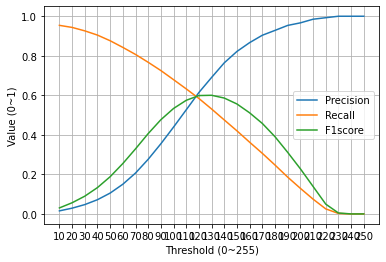

In [46]:
fig = plt.figure()
plt.plot(df_train["Threshold"], df_train["Precision"], label="Precision")
plt.plot(df_train["Threshold"], df_train["Recall"], label="Recall")
plt.plot(df_train["Threshold"], df_train["F1score"], label="F1score")
plt.xlabel("Threshold (0~255)")
plt.ylabel("Value (0~1)")
plt.grid()
plt.legend()

In [47]:
dir_list = glob.glob("threshold/2048_64/*/test")

multi_num = 8
p = Pool(multi_num)
d = p.map(calculate_F1, dir_list)
print(d)
p.close()

wsi_id: 14 TP: 42 FP: 107 FN: 22 F1: 0.39436619718309857
wsi_id: 14 TP:wsi_id: 5  FP:14  TP:0  45FN: FP: wsi_id: 59wsi_id:296   F1:14 FN:   140.14492753623188406TP: 19 
TP: 43  22FP:  FP:179 3  FN:FN:F1:   2142 0.22222222222222224 F1:
F1:  0.49438202247191015
0.30069930069930073
wsi_id: 14 TP: 59 FP: 2478 FN: 5 F1: 0.04536716647443291
wsi_id: 14 TP: 62 FP: 4592 FN: 2 F1: 0.026282323018228065
wsi_id: 15 TP: 154 FP: 4 FN: 715wsi_id:  F1:15  TP: 0.29990262901655307599
 FP: 746 FN: 270 F1: 0.5411020776874436
wsi_id:wsi_id: 15  15TP: TP: 672  374 FP:FP:  164996  FN:FN:  197495 wsi_id: F1: F1: 15  0.421316614420062630.5586258401792382TP:

 640 FP: 1087 FN: 229 F1: 0.4930662557781201
wsi_id: 14 TP: 62 FP: 10230 FN: 2 F1: 0.011973735032831211
wsi_id: 22 TP: 29 FP: 1 FN: 263 F1: wsi_id:0.18012422360248448 
22 TP: 210 FP: 528 FN: 82 F1: 0.4077669902912621
wsi_id:wsi_id: 22  22TP: 104  TP:FP:  30176  FP:FN:  188224  F1:FN:  0.48826291079812206116
 F1: 0.508670520231214
wsi_id: 22 TP: 192 FP: 336 

In [48]:
sorted_d = sorted(d, key=lambda x:(int(x[0]), int(x[1])))
df_test = pd.DataFrame(sorted_d)
df_test.columns = ["Threshold", "Precision", "Recall", "F1score"]
#df.to_csv("result.csv")
print(df_test)

   Threshold  Precision    Recall   F1score
0         10   0.022501  0.949004  0.043960
1         20   0.046124  0.938159  0.087925
2         30   0.077341  0.912661  0.142599
3         40   0.119225  0.880422  0.210011
4         50   0.174162  0.847890  0.288968
5         60   0.240833  0.810375  0.371315
6         70   0.321918  0.771395  0.454263
7         80   0.407821  0.727433  0.522636
8         90   0.495129  0.685229  0.574871
9        100   0.579342  0.634525  0.605679
10       110   0.657749  0.590856  0.622510
11       120   0.728278  0.540445  0.620458
12       130   0.791094  0.489449  0.604744
13       140   0.835177  0.442556  0.578544
14       150   0.863995  0.385404  0.533036
15       160   0.896471  0.334994  0.487732
16       170   0.927412  0.284584  0.435524
17       180   0.948503  0.232122  0.372969
18       190   0.969889  0.179367  0.302745
19       200   0.975446  0.128077  0.226425
20       210   0.973485  0.075322  0.139826
21       220   0.962963  0.03048

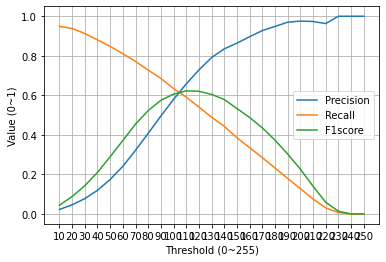

In [49]:
fig = plt.figure()
plt.plot(df_test["Threshold"], df_test["Precision"], label="Precision")
plt.plot(df_test["Threshold"], df_test["Recall"], label="Recall")
plt.plot(df_test["Threshold"], df_test["F1score"], label="F1score")
plt.xlabel("Threshold (0~255)")
plt.ylabel("Value (0~1)")
plt.grid()
plt.legend()

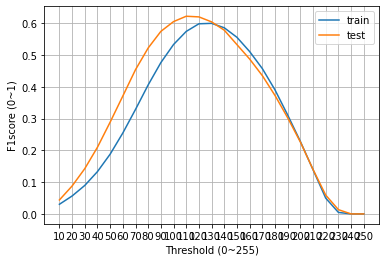

In [50]:
fig = plt.figure()
plt.plot(df_train["Threshold"], df_train["F1score"], label="train")
plt.plot(df_test["Threshold"], df_test["F1score"], label="test")
plt.xlabel("Threshold (0~255)")
plt.ylabel("F1score (0~1)")
plt.grid()
plt.legend()

In [51]:
df_train.to_csv("./train_result.csv")


df_test.to_csv("./test_result.csv")